## Libs Installation

In [1]:
!pip3 install torchmetrics gdown segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=d60e684d089e6825d1a79b1b6f3851f54abe0206bdfb89552368b4be5f95c581
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=73724c349ca5d69f80c5aa9b968de4a6c5bd7a5478100e4ce1408145d1ea96b9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

## Imports

In [2]:
# Main
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Type Hints
from typing import List, Dict, Tuple, Any
from torch.optim import Optimizer
from torch.nn.modules.loss import _Loss

# Data Preprocessing
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader

# Metrics and Loss Stuff
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice
from torchvision.ops import sigmoid_focal_loss

# Visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Other
import os
import warnings
warnings.filterwarnings("ignore")

## Data Download

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>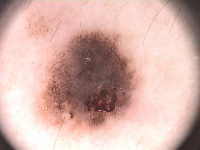</td><td>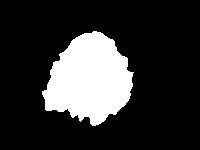</td></tr></table>

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [5]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [6]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

In [3]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 3.31MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 7.28MB/s]
Download completed


In [8]:
!ls "/kaggle/input/ph2dataset/PH2Dataset/PH2 Dataset images/"

IMD002	IMD027	IMD057	IMD112	IMD152	IMD182	IMD256	IMD367	IMD390	IMD413
IMD003	IMD030	IMD058	IMD118	IMD153	IMD196	IMD278	IMD368	IMD392	IMD417
IMD004	IMD031	IMD061	IMD120	IMD154	IMD197	IMD279	IMD369	IMD393	IMD418
IMD006	IMD032	IMD063	IMD125	IMD155	IMD198	IMD280	IMD370	IMD394	IMD419
IMD008	IMD033	IMD064	IMD126	IMD156	IMD199	IMD284	IMD371	IMD395	IMD420
IMD009	IMD035	IMD065	IMD132	IMD157	IMD200	IMD285	IMD372	IMD396	IMD421
IMD010	IMD036	IMD075	IMD133	IMD159	IMD203	IMD304	IMD374	IMD397	IMD423
IMD013	IMD037	IMD076	IMD134	IMD160	IMD204	IMD305	IMD375	IMD398	IMD424
IMD014	IMD038	IMD078	IMD135	IMD161	IMD206	IMD306	IMD376	IMD399	IMD425
IMD015	IMD039	IMD080	IMD137	IMD162	IMD207	IMD312	IMD378	IMD400	IMD426
IMD016	IMD040	IMD085	IMD138	IMD164	IMD208	IMD328	IMD379	IMD402	IMD427
IMD017	IMD041	IMD088	IMD139	IMD166	IMD210	IMD331	IMD380	IMD403	IMD429
IMD018	IMD042	IMD090	IMD140	IMD168	IMD211	IMD339	IMD381	IMD404	IMD430
IMD019	IMD043	IMD091	IMD142	IMD169	IMD219	IMD347	IMD382	IMD405	IMD431
IMD020	IMD044	IMD092

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

## Data Preprocessing

In [4]:
class LesionsDataset(Dataset):
    def __init__(self, images: List[str], masks: List[str], transforms: Dict[str, v2.Compose] = None) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])

        if self.transforms:
            image = self.transforms["image"](image)
            mask = self.transforms["mask"](mask)
        
        return (image, mask)    

In [5]:
image_transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  
])

mask_transform = v2.Compose([
    v2.Resize((256, 256), interpolation=v2.InterpolationMode.NEAREST),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
transforms = {
    "image": image_transform,
    "mask": mask_transform
}

In [1]:
images = []
lesions = []
root = '/kaggle/input/ph2dataset/PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(os.path.join(root, files[0]))
    if root.endswith('_lesion'):
        lesions.append(os.path.join(root, files[0]))

NameError: name 'os' is not defined

In [12]:
images[0], lesions[0]

('/kaggle/input/ph2dataset/PH2Dataset/PH2 Dataset images/IMD436/IMD436_Dermoscopic_Image/IMD436.bmp',
 '/kaggle/input/ph2dataset/PH2Dataset/PH2 Dataset images/IMD436/IMD436_lesion/IMD436_lesion.bmp')

In [13]:
def draw_data(image_path: str, lesion_path: str) -> None:
    _, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].imshow(Image.open(image_path))
    ax[1].imshow(Image.open(lesion_path))
    ax[0].set_title("Image")
    ax[1].set_title("Lesion Mask")
    plt.show()

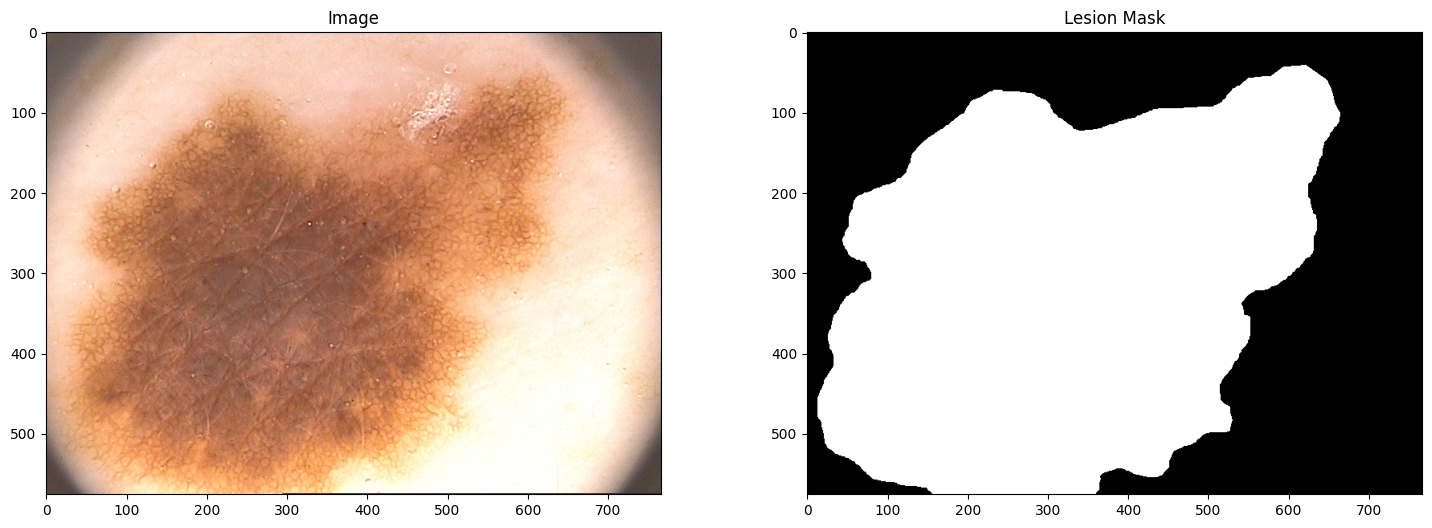

In [14]:
draw_data(images[0], lesions[0])

In [7]:
dataset = LesionsDataset(images=images, masks=lesions, transforms=transforms)

In [16]:
len(dataset)

200

In [8]:
train_set, val_set, test_set = random_split(dataset, [100, 50, 50])

In [9]:
batch_size = 25
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=4, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

In [20]:
iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [21]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [22]:
def bce_loss(y_pred, y_real):
    loss = 0.
    for i in range(y_pred.shape[0]):
        loss += y_pred[i] - (y_pred[i] * y_real[i]) + np.log(1 + np.exp(- y_pred[i]))
    return torch.sum(loss)
    
def bce_true(y_pred, y_real):
    loss = 0.
    for i in range(y_pred.shape[0]):
        loss += - y_real[i] * np.log(F.sigmoid(y_pred[i])) - (1 - y_real[i]) * np.log(1 - F.sigmoid(y_pred[i]))
    return torch.sum(loss)

Проверим корректность работы на простом примере

In [23]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss = 5.366549015045166
BCE loss честно посчитанный = 5.366549015045166
BCE loss from torch bce_torch = 5.366549491882324
BCE loss from torch with logits bce_torch = 5.366549491882324


In [24]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [25]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.71525764465332
BCE loss честно посчитанный = 14.715255737304688
BCE loss from torch bce_torch = 14.71525764465332
BCE loss from torch with logits bce_torch = 14.715256690979004


In [26]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [11]:
path_to_dummy_samples = '/kaggle/working/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

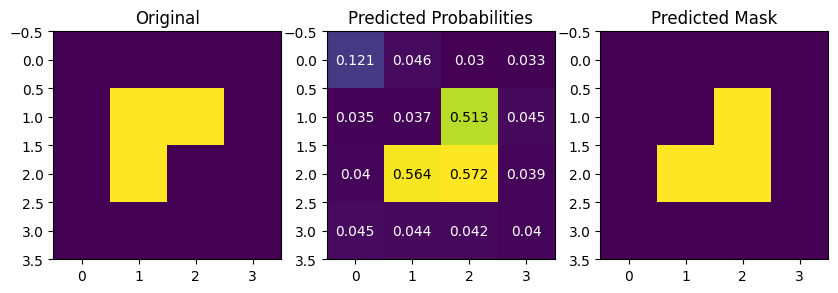

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [29]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet


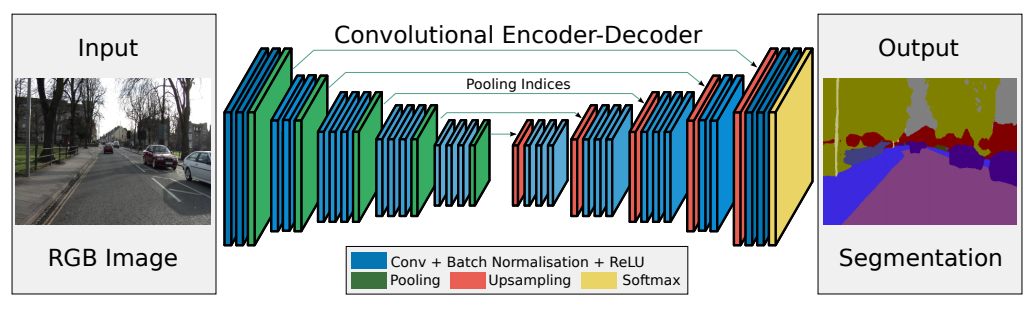

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [12]:
class ConvReLU(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, padding: int = 1) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.bn(X)
        X = self.relu(X)
        return X

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, depth: int = 2, kernel_size: int = 3, padding: int = 1) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_channels if i == 0 else out_channels, out_channels, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, X: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        for layer in self.layers:
            X = layer(X)
        X, ind = self.pool(X)
        return (X, ind)

In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, depth: int = 2, kernel_size: int = 3, padding: int = 1, classification: bool = False) -> None:
        super().__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_channels, in_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, X: torch.Tensor, ind: torch.Tensor) -> torch.Tensor:
        X = self.unpool(X, ind)
        for layer in self.layers:
            X = layer(X)
        return X

In [15]:
class SegNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, features: int = 64):
        super().__init__()
        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3) 
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3) 

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # encoder
        e0, ind0 = self.enc0(X) 
        e1, ind1 = self.enc1(e0) 
        e2, ind2 = self.enc2(e1) 
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)  
        return output

In [16]:
segnet_model = SegNet().to(device)

## Training

In [17]:
def train(
    model: SegNet,
    data: Dict[str, DataLoader],
    criterion: _Loss,
    optimizer: Optimizer,
    metrics: JaccardIndex,
    checkpoint_path: str = "/kaggle/working",
    epochs: int = 10,
    device: torch.device = "cpu"
) -> Tuple[SegNet, Dict[str, List[float]]]:
    statistics = {
      "total_train_loss": [],
      "total_train_iou": [],
      "total_val_loss": [],
      "total_val_iou": []
    }
    best_val_score = 0.

    for i in range(epochs):

        epoch_train_loss = []
        epoch_train_iou = []
        epoch_val_loss = []
        epoch_val_iou = []

        model.train()
        with tqdm(data["train"], desc=f"Training Epoch {i + 1}/{epochs}", unit="batch") as train_pbar:
            for X_batch, Y_batch in train_pbar:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                optimizer.zero_grad()
                logits = model(X_batch)
                loss = criterion(logits, Y_batch)
                iou_score = metrics(logits, Y_batch)
                loss.backward()
                optimizer.step()
                epoch_train_loss.append(loss.detach().cpu().item())
                epoch_train_iou.append(iou_score.detach().cpu().item())

                train_pbar.update(1)
            current_train_loss = sum(epoch_train_loss) / len(epoch_train_loss)
            current_train_iou = sum(epoch_train_iou) / len(epoch_train_iou)
            train_pbar.write(f"Training Epoch {i + 1}/{epochs}: Loss - {current_train_loss:0.4f}, Mean IoU - {current_train_iou:0.4f}")
        
        
        model.eval()
        with tqdm(data["validation"], desc=f"Validation Epoch {i + 1}/{epochs}", unit="batch") as val_pbar:
            with torch.inference_mode():
                for X_batch, Y_batch in val_pbar:
                    X_batch = X_batch.to(device)
                    Y_batch = Y_batch.to(device)
    
                    logits = model(X_batch)
                    loss = criterion(logits, Y_batch)
                    iou_score = metrics(logits, Y_batch)
                    epoch_val_loss.append(loss.detach().cpu().item())
                    epoch_val_iou.append(iou_score.detach().cpu().item())
    
                    val_pbar.update(1)
                current_val_loss = sum(epoch_val_loss) / len(epoch_val_loss)
                current_val_iou = sum(epoch_val_iou) / len(epoch_val_iou)
                val_pbar.write(f"Validation Epoch {i + 1}/{epochs}: Loss - {current_val_loss:0.4f}, Mean IoU - {current_val_iou:0.4f}")

        if current_val_iou > best_val_score:
            best_val_score = current_val_iou
            torch.save(model.state_dict(), f"{os.path.join(checkpoint_path, 'epoch_{0}.pt'.format(i))}")
            best_model = model
            

        statistics["total_train_loss"].append(current_train_loss)
        statistics["total_train_iou"].append(current_train_iou)
        statistics["total_val_loss"].append(current_val_loss)
        statistics["total_val_iou"].append(current_val_iou)
    return best_model, statistics

In [18]:
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
dataloader = {
    "train": train_loader,
    "validation": val_loader
}
metrics = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [37]:
best_model, statistics = train(
    model=segnet_model,
    data=dataloader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    epochs=100,
    device=device
)

Training Epoch 1/100: 100%|██████████| 4/4 [00:05<00:00,  1.46s/batch]


Training Epoch 1/100: Loss - 0.6746, Mean IoU - 0.1760


Validation Epoch 1/100: 100%|██████████| 2/2 [00:01<00:00,  1.19batch/s]


Validation Epoch 1/100: Loss - 0.8744, Mean IoU - 0.2614


Training Epoch 2/100: 100%|██████████| 4/4 [00:04<00:00,  1.11s/batch]


Training Epoch 2/100: Loss - 0.5838, Mean IoU - 0.3233


Validation Epoch 2/100: 100%|██████████| 2/2 [00:01<00:00,  1.80batch/s]


Validation Epoch 2/100: Loss - 8.6069, Mean IoU - 0.2879


Training Epoch 3/100: 100%|██████████| 4/4 [00:04<00:00,  1.11s/batch]


Training Epoch 3/100: Loss - 0.4640, Mean IoU - 0.4421


Validation Epoch 3/100: 100%|██████████| 2/2 [00:01<00:00,  1.83batch/s]


Validation Epoch 3/100: Loss - 33.5820, Mean IoU - 0.3424


Training Epoch 4/100: 100%|██████████| 4/4 [00:04<00:00,  1.12s/batch]


Training Epoch 4/100: Loss - 0.3357, Mean IoU - 0.6590


Validation Epoch 4/100: 100%|██████████| 2/2 [00:01<00:00,  1.84batch/s]


Validation Epoch 4/100: Loss - 0.5882, Mean IoU - 0.0788


Training Epoch 5/100: 100%|██████████| 4/4 [00:04<00:00,  1.12s/batch]


Training Epoch 5/100: Loss - 0.2851, Mean IoU - 0.6997


Validation Epoch 5/100: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 5/100: Loss - 0.2959, Mean IoU - 0.6899


Training Epoch 6/100: 100%|██████████| 4/4 [00:04<00:00,  1.14s/batch]


Training Epoch 6/100: Loss - 0.2232, Mean IoU - 0.7615


Validation Epoch 6/100: 100%|██████████| 2/2 [00:01<00:00,  1.81batch/s]


Validation Epoch 6/100: Loss - 0.8458, Mean IoU - 0.0624


Training Epoch 7/100: 100%|██████████| 4/4 [00:04<00:00,  1.13s/batch]


Training Epoch 7/100: Loss - 0.2365, Mean IoU - 0.7398


Validation Epoch 7/100: 100%|██████████| 2/2 [00:01<00:00,  1.85batch/s]


Validation Epoch 7/100: Loss - 0.3570, Mean IoU - 0.6919


Training Epoch 8/100: 100%|██████████| 4/4 [00:04<00:00,  1.13s/batch]


Training Epoch 8/100: Loss - 0.2327, Mean IoU - 0.7219


Validation Epoch 8/100: 100%|██████████| 2/2 [00:01<00:00,  1.79batch/s]


Validation Epoch 8/100: Loss - 0.3444, Mean IoU - 0.5973


Training Epoch 9/100: 100%|██████████| 4/4 [00:04<00:00,  1.14s/batch]


Training Epoch 9/100: Loss - 0.2168, Mean IoU - 0.7493


Validation Epoch 9/100: 100%|██████████| 2/2 [00:01<00:00,  1.77batch/s]


Validation Epoch 9/100: Loss - 0.3459, Mean IoU - 0.6300


Training Epoch 10/100: 100%|██████████| 4/4 [00:04<00:00,  1.15s/batch]


Training Epoch 10/100: Loss - 0.1945, Mean IoU - 0.7627


Validation Epoch 10/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 10/100: Loss - 0.2671, Mean IoU - 0.7381


Training Epoch 11/100: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 11/100: Loss - 0.1795, Mean IoU - 0.7699


Validation Epoch 11/100: 100%|██████████| 2/2 [00:01<00:00,  1.78batch/s]


Validation Epoch 11/100: Loss - 0.3072, Mean IoU - 0.6883


Training Epoch 12/100: 100%|██████████| 4/4 [00:04<00:00,  1.14s/batch]


Training Epoch 12/100: Loss - 0.2073, Mean IoU - 0.7639


Validation Epoch 12/100: 100%|██████████| 2/2 [00:01<00:00,  1.83batch/s]


Validation Epoch 12/100: Loss - 0.4285, Mean IoU - 0.4756


Training Epoch 13/100: 100%|██████████| 4/4 [00:04<00:00,  1.15s/batch]


Training Epoch 13/100: Loss - 0.1815, Mean IoU - 0.7835


Validation Epoch 13/100: 100%|██████████| 2/2 [00:01<00:00,  1.80batch/s]


Validation Epoch 13/100: Loss - 0.3009, Mean IoU - 0.6276


Training Epoch 14/100: 100%|██████████| 4/4 [00:04<00:00,  1.15s/batch]


Training Epoch 14/100: Loss - 0.1606, Mean IoU - 0.8077


Validation Epoch 14/100: 100%|██████████| 2/2 [00:01<00:00,  1.76batch/s]


Validation Epoch 14/100: Loss - 0.2276, Mean IoU - 0.7512


Training Epoch 15/100: 100%|██████████| 4/4 [00:04<00:00,  1.16s/batch]


Training Epoch 15/100: Loss - 0.1670, Mean IoU - 0.7907


Validation Epoch 15/100: 100%|██████████| 2/2 [00:01<00:00,  1.78batch/s]


Validation Epoch 15/100: Loss - 0.1877, Mean IoU - 0.7831


Training Epoch 16/100: 100%|██████████| 4/4 [00:04<00:00,  1.17s/batch]


Training Epoch 16/100: Loss - 0.1623, Mean IoU - 0.7985


Validation Epoch 16/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 16/100: Loss - 0.2047, Mean IoU - 0.7586


Training Epoch 17/100: 100%|██████████| 4/4 [00:04<00:00,  1.17s/batch]


Training Epoch 17/100: Loss - 0.1748, Mean IoU - 0.8006


Validation Epoch 17/100: 100%|██████████| 2/2 [00:01<00:00,  1.78batch/s]


Validation Epoch 17/100: Loss - 0.4017, Mean IoU - 0.5146


Training Epoch 18/100: 100%|██████████| 4/4 [00:04<00:00,  1.16s/batch]


Training Epoch 18/100: Loss - 0.1905, Mean IoU - 0.7880


Validation Epoch 18/100: 100%|██████████| 2/2 [00:01<00:00,  1.79batch/s]


Validation Epoch 18/100: Loss - 0.6000, Mean IoU - 0.2531


Training Epoch 19/100: 100%|██████████| 4/4 [00:04<00:00,  1.17s/batch]


Training Epoch 19/100: Loss - 0.1640, Mean IoU - 0.7994


Validation Epoch 19/100: 100%|██████████| 2/2 [00:01<00:00,  1.83batch/s]


Validation Epoch 19/100: Loss - 0.1811, Mean IoU - 0.7580


Training Epoch 20/100: 100%|██████████| 4/4 [00:04<00:00,  1.17s/batch]


Training Epoch 20/100: Loss - 0.1551, Mean IoU - 0.8141


Validation Epoch 20/100: 100%|██████████| 2/2 [00:01<00:00,  1.77batch/s]


Validation Epoch 20/100: Loss - 0.2057, Mean IoU - 0.7479


Training Epoch 21/100: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 21/100: Loss - 0.1818, Mean IoU - 0.7842


Validation Epoch 21/100: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 21/100: Loss - 0.3361, Mean IoU - 0.5732


Training Epoch 22/100: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 22/100: Loss - 0.1732, Mean IoU - 0.7764


Validation Epoch 22/100: 100%|██████████| 2/2 [00:01<00:00,  1.81batch/s]


Validation Epoch 22/100: Loss - 0.3773, Mean IoU - 0.5746


Training Epoch 23/100: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 23/100: Loss - 0.1649, Mean IoU - 0.7854


Validation Epoch 23/100: 100%|██████████| 2/2 [00:01<00:00,  1.78batch/s]


Validation Epoch 23/100: Loss - 0.2346, Mean IoU - 0.7404


Training Epoch 24/100: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 24/100: Loss - 0.1392, Mean IoU - 0.8307


Validation Epoch 24/100: 100%|██████████| 2/2 [00:01<00:00,  1.77batch/s]


Validation Epoch 24/100: Loss - 0.4094, Mean IoU - 0.6626


Training Epoch 25/100: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 25/100: Loss - 0.1426, Mean IoU - 0.8170


Validation Epoch 25/100: 100%|██████████| 2/2 [00:01<00:00,  1.77batch/s]


Validation Epoch 25/100: Loss - 0.2543, Mean IoU - 0.7436


Training Epoch 26/100: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 26/100: Loss - 0.1562, Mean IoU - 0.8125


Validation Epoch 26/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 26/100: Loss - 0.3799, Mean IoU - 0.6635


Training Epoch 27/100: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 27/100: Loss - 0.1512, Mean IoU - 0.8085


Validation Epoch 27/100: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 27/100: Loss - 0.2874, Mean IoU - 0.7048


Training Epoch 28/100: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 28/100: Loss - 0.1482, Mean IoU - 0.8069


Validation Epoch 28/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 28/100: Loss - 0.1998, Mean IoU - 0.7775


Training Epoch 29/100: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 29/100: Loss - 0.1438, Mean IoU - 0.8221


Validation Epoch 29/100: 100%|██████████| 2/2 [00:01<00:00,  1.79batch/s]


Validation Epoch 29/100: Loss - 0.1588, Mean IoU - 0.8119


Training Epoch 30/100: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 30/100: Loss - 0.1291, Mean IoU - 0.8357


Validation Epoch 30/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 30/100: Loss - 0.1532, Mean IoU - 0.8258


Training Epoch 31/100: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 31/100: Loss - 0.1398, Mean IoU - 0.8223


Validation Epoch 31/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 31/100: Loss - 0.1608, Mean IoU - 0.8106


Training Epoch 32/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 32/100: Loss - 0.1421, Mean IoU - 0.8220


Validation Epoch 32/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 32/100: Loss - 0.2249, Mean IoU - 0.7225


Training Epoch 33/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 33/100: Loss - 0.1208, Mean IoU - 0.8504


Validation Epoch 33/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 33/100: Loss - 0.2140, Mean IoU - 0.7195


Training Epoch 34/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 34/100: Loss - 0.1892, Mean IoU - 0.7721


Validation Epoch 34/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 34/100: Loss - 0.1751, Mean IoU - 0.7815


Training Epoch 35/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 35/100: Loss - 0.1408, Mean IoU - 0.8144


Validation Epoch 35/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 35/100: Loss - 0.2012, Mean IoU - 0.7446


Training Epoch 36/100: 100%|██████████| 4/4 [00:04<00:00,  1.24s/batch]


Training Epoch 36/100: Loss - 0.1390, Mean IoU - 0.8180


Validation Epoch 36/100: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 36/100: Loss - 0.3998, Mean IoU - 0.5876


Training Epoch 37/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 37/100: Loss - 0.1366, Mean IoU - 0.8414


Validation Epoch 37/100: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 37/100: Loss - 0.1920, Mean IoU - 0.7788


Training Epoch 38/100: 100%|██████████| 4/4 [00:04<00:00,  1.24s/batch]


Training Epoch 38/100: Loss - 0.1373, Mean IoU - 0.8301


Validation Epoch 38/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 38/100: Loss - 0.1705, Mean IoU - 0.8249


Training Epoch 39/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 39/100: Loss - 0.1299, Mean IoU - 0.8353


Validation Epoch 39/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 39/100: Loss - 0.2081, Mean IoU - 0.7974


Training Epoch 40/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 40/100: Loss - 0.1389, Mean IoU - 0.8249


Validation Epoch 40/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 40/100: Loss - 0.1657, Mean IoU - 0.8151


Training Epoch 41/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 41/100: Loss - 0.1283, Mean IoU - 0.8394


Validation Epoch 41/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 41/100: Loss - 0.1442, Mean IoU - 0.8396


Training Epoch 42/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 42/100: Loss - 0.1886, Mean IoU - 0.7731


Validation Epoch 42/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 42/100: Loss - 0.1928, Mean IoU - 0.7623


Training Epoch 43/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 43/100: Loss - 0.1460, Mean IoU - 0.8163


Validation Epoch 43/100: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 43/100: Loss - 0.2114, Mean IoU - 0.7374


Training Epoch 44/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 44/100: Loss - 0.1623, Mean IoU - 0.8059


Validation Epoch 44/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 44/100: Loss - 0.2565, Mean IoU - 0.7015


Training Epoch 45/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 45/100: Loss - 0.1398, Mean IoU - 0.8307


Validation Epoch 45/100: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 45/100: Loss - 1.0735, Mean IoU - 0.3452


Training Epoch 46/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 46/100: Loss - 0.1244, Mean IoU - 0.8488


Validation Epoch 46/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 46/100: Loss - 0.1545, Mean IoU - 0.8278


Training Epoch 47/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 47/100: Loss - 0.1517, Mean IoU - 0.7995


Validation Epoch 47/100: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 47/100: Loss - 0.1799, Mean IoU - 0.8207


Training Epoch 48/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 48/100: Loss - 0.1450, Mean IoU - 0.8087


Validation Epoch 48/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 48/100: Loss - 0.3357, Mean IoU - 0.6600


Training Epoch 49/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 49/100: Loss - 0.1251, Mean IoU - 0.8488


Validation Epoch 49/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 49/100: Loss - 0.1910, Mean IoU - 0.7648


Training Epoch 50/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 50/100: Loss - 0.1360, Mean IoU - 0.8314


Validation Epoch 50/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 50/100: Loss - 0.2152, Mean IoU - 0.7667


Training Epoch 51/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 51/100: Loss - 0.1396, Mean IoU - 0.8242


Validation Epoch 51/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 51/100: Loss - 0.1479, Mean IoU - 0.8222


Training Epoch 52/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 52/100: Loss - 0.1078, Mean IoU - 0.8601


Validation Epoch 52/100: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 52/100: Loss - 0.1500, Mean IoU - 0.8215


Training Epoch 53/100: 100%|██████████| 4/4 [00:04<00:00,  1.24s/batch]


Training Epoch 53/100: Loss - 0.1344, Mean IoU - 0.8337


Validation Epoch 53/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 53/100: Loss - 0.1427, Mean IoU - 0.8341


Training Epoch 54/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 54/100: Loss - 0.1072, Mean IoU - 0.8673


Validation Epoch 54/100: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 54/100: Loss - 0.1487, Mean IoU - 0.8333


Training Epoch 55/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 55/100: Loss - 0.1168, Mean IoU - 0.8530


Validation Epoch 55/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 55/100: Loss - 0.1548, Mean IoU - 0.8264


Training Epoch 56/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 56/100: Loss - 0.1167, Mean IoU - 0.8518


Validation Epoch 56/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 56/100: Loss - 0.2143, Mean IoU - 0.7679


Training Epoch 57/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 57/100: Loss - 0.1247, Mean IoU - 0.8453


Validation Epoch 57/100: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 57/100: Loss - 0.1742, Mean IoU - 0.7804


Training Epoch 58/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 58/100: Loss - 0.1096, Mean IoU - 0.8621


Validation Epoch 58/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 58/100: Loss - 0.1670, Mean IoU - 0.7928


Training Epoch 59/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 59/100: Loss - 0.1263, Mean IoU - 0.8505


Validation Epoch 59/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 59/100: Loss - 0.1522, Mean IoU - 0.8230


Training Epoch 60/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 60/100: Loss - 0.1561, Mean IoU - 0.8104


Validation Epoch 60/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 60/100: Loss - 0.2097, Mean IoU - 0.7789


Training Epoch 61/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 61/100: Loss - 0.1321, Mean IoU - 0.8251


Validation Epoch 61/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 61/100: Loss - 0.1548, Mean IoU - 0.8126


Training Epoch 62/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 62/100: Loss - 0.1246, Mean IoU - 0.8278


Validation Epoch 62/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 62/100: Loss - 0.1651, Mean IoU - 0.8063


Training Epoch 63/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 63/100: Loss - 0.1145, Mean IoU - 0.8581


Validation Epoch 63/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 63/100: Loss - 0.1530, Mean IoU - 0.8245


Training Epoch 64/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 64/100: Loss - 0.1227, Mean IoU - 0.8454


Validation Epoch 64/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 64/100: Loss - 0.1561, Mean IoU - 0.8261


Training Epoch 65/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 65/100: Loss - 0.1136, Mean IoU - 0.8560


Validation Epoch 65/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 65/100: Loss - 0.2149, Mean IoU - 0.8075


Training Epoch 66/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 66/100: Loss - 0.1432, Mean IoU - 0.8328


Validation Epoch 66/100: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 66/100: Loss - 0.1748, Mean IoU - 0.8277


Training Epoch 67/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 67/100: Loss - 0.1158, Mean IoU - 0.8476


Validation Epoch 67/100: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 67/100: Loss - 0.1394, Mean IoU - 0.8367


Training Epoch 68/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 68/100: Loss - 0.1041, Mean IoU - 0.8741


Validation Epoch 68/100: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 68/100: Loss - 0.1421, Mean IoU - 0.8365


Training Epoch 69/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 69/100: Loss - 0.0967, Mean IoU - 0.8746


Validation Epoch 69/100: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 69/100: Loss - 0.1447, Mean IoU - 0.8368


Training Epoch 70/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 70/100: Loss - 0.1181, Mean IoU - 0.8560


Validation Epoch 70/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 70/100: Loss - 0.1477, Mean IoU - 0.8318


Training Epoch 71/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 71/100: Loss - 0.1291, Mean IoU - 0.8427


Validation Epoch 71/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 71/100: Loss - 0.1394, Mean IoU - 0.8285


Training Epoch 72/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 72/100: Loss - 0.1043, Mean IoU - 0.8680


Validation Epoch 72/100: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 72/100: Loss - 0.1332, Mean IoU - 0.8345


Training Epoch 73/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 73/100: Loss - 0.1000, Mean IoU - 0.8626


Validation Epoch 73/100: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 73/100: Loss - 0.1434, Mean IoU - 0.8314


Training Epoch 74/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 74/100: Loss - 0.1063, Mean IoU - 0.8655


Validation Epoch 74/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 74/100: Loss - 0.1739, Mean IoU - 0.8110


Training Epoch 75/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 75/100: Loss - 0.1215, Mean IoU - 0.8433


Validation Epoch 75/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 75/100: Loss - 0.1899, Mean IoU - 0.7934


Training Epoch 76/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 76/100: Loss - 0.1113, Mean IoU - 0.8572


Validation Epoch 76/100: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 76/100: Loss - 0.1711, Mean IoU - 0.8224


Training Epoch 77/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 77/100: Loss - 0.1154, Mean IoU - 0.8497


Validation Epoch 77/100: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 77/100: Loss - 0.1267, Mean IoU - 0.8545


Training Epoch 78/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 78/100: Loss - 0.1006, Mean IoU - 0.8669


Validation Epoch 78/100: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 78/100: Loss - 0.1328, Mean IoU - 0.8446


Training Epoch 79/100: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 79/100: Loss - 0.0922, Mean IoU - 0.8780


Validation Epoch 79/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 79/100: Loss - 0.1437, Mean IoU - 0.8371


Training Epoch 80/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 80/100: Loss - 0.0986, Mean IoU - 0.8712


Validation Epoch 80/100: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 80/100: Loss - 0.1632, Mean IoU - 0.8334


Training Epoch 81/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 81/100: Loss - 0.0921, Mean IoU - 0.8837


Validation Epoch 81/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 81/100: Loss - 0.1631, Mean IoU - 0.8238


Training Epoch 82/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 82/100: Loss - 0.1117, Mean IoU - 0.8574


Validation Epoch 82/100: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 82/100: Loss - 0.1491, Mean IoU - 0.8267


Training Epoch 83/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 83/100: Loss - 0.0996, Mean IoU - 0.8685


Validation Epoch 83/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 83/100: Loss - 0.1636, Mean IoU - 0.8185


Training Epoch 84/100: 100%|██████████| 4/4 [00:04<00:00,  1.24s/batch]


Training Epoch 84/100: Loss - 0.1104, Mean IoU - 0.8560


Validation Epoch 84/100: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s]


Validation Epoch 84/100: Loss - 0.1499, Mean IoU - 0.8176


Training Epoch 85/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 85/100: Loss - 0.1004, Mean IoU - 0.8747


Validation Epoch 85/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 85/100: Loss - 0.1485, Mean IoU - 0.8253


Training Epoch 86/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 86/100: Loss - 0.0875, Mean IoU - 0.8862


Validation Epoch 86/100: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 86/100: Loss - 0.1479, Mean IoU - 0.8367


Training Epoch 87/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 87/100: Loss - 0.0895, Mean IoU - 0.8840


Validation Epoch 87/100: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 87/100: Loss - 0.1506, Mean IoU - 0.8357


Training Epoch 88/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 88/100: Loss - 0.0786, Mean IoU - 0.8978


Validation Epoch 88/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 88/100: Loss - 0.1662, Mean IoU - 0.8276


Training Epoch 89/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 89/100: Loss - 0.0905, Mean IoU - 0.8815


Validation Epoch 89/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 89/100: Loss - 0.1755, Mean IoU - 0.8117


Training Epoch 90/100: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 90/100: Loss - 0.0792, Mean IoU - 0.8962


Validation Epoch 90/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 90/100: Loss - 0.1687, Mean IoU - 0.8176


Training Epoch 91/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 91/100: Loss - 0.1006, Mean IoU - 0.8775


Validation Epoch 91/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 91/100: Loss - 0.1487, Mean IoU - 0.8303


Training Epoch 92/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 92/100: Loss - 0.0885, Mean IoU - 0.8886


Validation Epoch 92/100: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 92/100: Loss - 0.1411, Mean IoU - 0.8415


Training Epoch 93/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 93/100: Loss - 0.0833, Mean IoU - 0.8918


Validation Epoch 93/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 93/100: Loss - 0.1286, Mean IoU - 0.8558


Training Epoch 94/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 94/100: Loss - 0.0712, Mean IoU - 0.9088


Validation Epoch 94/100: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 94/100: Loss - 0.1300, Mean IoU - 0.8537


Training Epoch 95/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 95/100: Loss - 0.0842, Mean IoU - 0.8916


Validation Epoch 95/100: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 95/100: Loss - 0.1369, Mean IoU - 0.8528


Training Epoch 96/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 96/100: Loss - 0.0797, Mean IoU - 0.8922


Validation Epoch 96/100: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 96/100: Loss - 0.1651, Mean IoU - 0.8319


Training Epoch 97/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 97/100: Loss - 0.1583, Mean IoU - 0.8286


Validation Epoch 97/100: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 97/100: Loss - 0.1900, Mean IoU - 0.8081


Training Epoch 98/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 98/100: Loss - 0.1041, Mean IoU - 0.8675


Validation Epoch 98/100: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 98/100: Loss - 0.2030, Mean IoU - 0.7900


Training Epoch 99/100: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 99/100: Loss - 0.1396, Mean IoU - 0.8342


Validation Epoch 99/100: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 99/100: Loss - 0.2208, Mean IoU - 0.7920


Training Epoch 100/100: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 100/100: Loss - 0.1276, Mean IoU - 0.8482


Validation Epoch 100/100: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]

Validation Epoch 100/100: Loss - 0.1974, Mean IoU - 0.8081


In [19]:
def draw_statistics(statistics: Dict[str, List[float]]) -> None:
    epochs = len(statistics["total_train_loss"])
    _, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(range(1, epochs + 1), statistics["total_train_loss"], label="Train Loss")
    ax[0].plot(range(1, epochs + 1), statistics["total_val_loss"], label="Validation Loss")
    ax[1].plot(range(1, epochs + 1), statistics["total_train_iou"], label="Train IoU")
    ax[1].plot(range(1, epochs + 1), statistics["total_val_iou"], label="Validation IoU")
    for i in [ax[0], ax[1]]:
        for tick in i.xaxis.get_major_ticks():
            tick.label.set_fontsize(10) 
        for tick in i.yaxis.get_major_ticks():
            tick.label.set_fontsize(10)
        i.set_xlabel("Epochs", size=15)
        i.legend(prop={'size': 15})
        i.grid()
    ax[0].set_title("Loss Statistics", size=30)
    ax[1].set_title("IoU Statistics", size=30)
    plt.show()

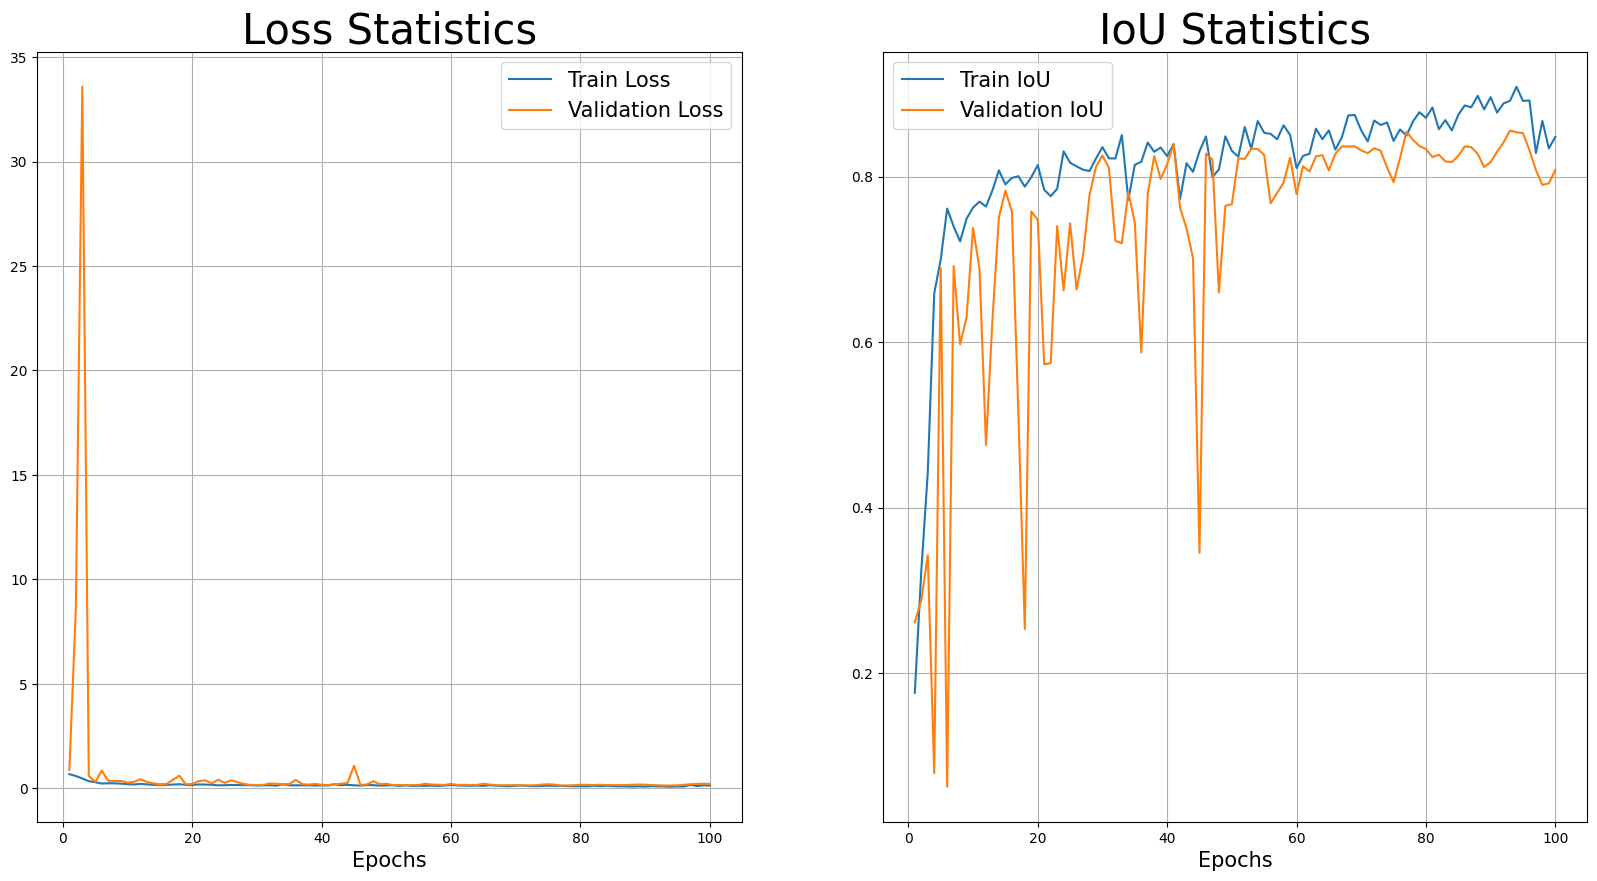

In [39]:
draw_statistics(statistics)

## Тестирование

In [1]:
def test(
    test_data: DataLoader,
    metrics: JaccardIndex,
    best_model: str | SegNet,
    device: torch.device = 'cpu',
) -> Dict[str, List[float]]:
    inference = {
        "total_test_iou": []
    }
    if isinstance(best_model, str):
        model = SegNet().to(device)
        model.load_state_dict(torch.load(best_model, weights_only=True))
    else:
        model = best_model
    model.eval()
    with tqdm(test_data, desc=f"Inference", unit="batch") as val_pbar:
        with torch.inference_mode():
            for X_batch, Y_batch in val_pbar:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                logits = model(X_batch)
                iou_score = metrics(logits, Y_batch)
                inference["total_test_iou"].append(iou_score.detach().cpu().item())

                val_pbar.update(1)
            mean_iou_score = sum(inference["total_test_iou"]) / len(inference["total_test_iou"])
            val_pbar.write(f"Mean IoU - {mean_iou_score:0.4f}")
    return inference

NameError: name 'DataLoader' is not defined

In [ ]:
inference = test(
    test_data=test_loader,
    device=device,
    metrics=metrics,
    best_model=best_model
)

Inference: 100%|██████████| 2/2 [00:01<00:00,  1.23batch/s]

Mean IoU - 0.7414


### Dice Loss

Итак, давайте сначала пропишем dice_score.

In [44]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    probs = logits.sigmoid()
    mask = (probs > threshold).float()
    tp = torch.sum(mask * labels)
    fp = torch.sum(mask) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return score

Проверим на корректность функцию dice_score:

In [45]:
dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [46]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [47]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    probs = logits.sigmoid()
    tp = torch.sum(probs * labels)
    fp = torch.sum(probs) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    dice_score = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    loss = 1 - dice_score
    return loss

Проверка на корректность:

In [48]:
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [49]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

In [50]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    p_t = y_pred.sigmoid() * y_real + (1 - y_pred.sigmoid()) * (1 - y_real)
    alpha = (1 - p_t) ** gamma
    loss = - alpha * ((y_real * torch.log(y_pred.sigmoid())) + (1 - y_real) * torch.log(1 - y_pred.sigmoid()))
    return torch.sum(loss)

Проверка корректности функции:

In [51]:
b = sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

In [52]:
b.cpu().detach().numpy()

array(3.6161237, dtype=float32)

In [53]:
a = focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

In [54]:
a.cpu().detach().numpy()

array(3.616124, dtype=float32)

In [55]:
assert np.isclose(b.cpu().detach().numpy(), a.cpu().detach().numpy())

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, gamma: float = 2.0) -> None:
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        l = inputs.reshape(-1)
        t = targets.reshape(-1)
        p = torch.sigmoid(l)
        p = torch.where(t >= 0.5, p, 1-p)
        logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
        loss = logp* ((1-p) ** self.gamma)
        loss = loss.sum()
        return loss

In [26]:
focal_loss = FocalLoss()
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(3.6161, device='cuda:0')

### Tversky Loss

In [37]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.5, beta: float = 0.5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor, smooth: int = 1) -> torch.Tensor:
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        tp = torch.sum(inputs * targets)
        fp = torch.sum(inputs) - tp
        fn = torch.sum(targets) - tp

        tversky = (tp + smooth) / (tp + self.alpha * fp + self.beta * fn + smooth)  
        
        return 1 - tversky

In [38]:
tversky_loss = TverskyLoss()
tversky_loss(dummpy_sample['labels'], dummpy_sample['logits'])

tensor(-0.3470, device='cuda:0')

In [39]:
dice_loss = DiceLoss(mode='binary')
focal_loss = FocalLoss()
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)

### SegNet + DiceLoss 

In [36]:
torch.cuda.empty_cache()

In [38]:
segnet_dice = SegNet().to(device)
optimizer_dice = torch.optim.Adam(segnet_dice.parameters(), lr=1e-3)

best_dice_model, statistics = train(
        model=segnet_dice,
        data=dataloader,
        optimizer=optimizer_dice,
        criterion=dice_loss,
        metrics=metrics,
        epochs=50,
        device=device
)

Training Epoch 1/50: 100%|██████████| 4/4 [00:05<00:00,  1.27s/batch]


Training Epoch 1/50: Loss - 0.6148, Mean IoU - 0.1267


Validation Epoch 1/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 1/50: Loss - 0.5868, Mean IoU - 0.3504


Training Epoch 2/50: 100%|██████████| 4/4 [00:05<00:00,  1.26s/batch]


Training Epoch 2/50: Loss - 0.5721, Mean IoU - 0.3234


Validation Epoch 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 2/50: Loss - 0.5829, Mean IoU - 0.3520


Training Epoch 3/50: 100%|██████████| 4/4 [00:05<00:00,  1.26s/batch]


Training Epoch 3/50: Loss - 0.5087, Mean IoU - 0.3230


Validation Epoch 3/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 3/50: Loss - 0.5397, Mean IoU - 0.3525


Training Epoch 4/50: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch]


Training Epoch 4/50: Loss - 0.4304, Mean IoU - 0.3920


Validation Epoch 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 4/50: Loss - 0.5595, Mean IoU - 0.2439


Training Epoch 5/50: 100%|██████████| 4/4 [00:05<00:00,  1.32s/batch]


Training Epoch 5/50: Loss - 0.3779, Mean IoU - 0.6468


Validation Epoch 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 5/50: Loss - 0.5990, Mean IoU - 0.0645


Training Epoch 6/50: 100%|██████████| 4/4 [00:05<00:00,  1.34s/batch]


Training Epoch 6/50: Loss - 0.3210, Mean IoU - 0.6986


Validation Epoch 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.58batch/s]


Validation Epoch 6/50: Loss - 0.3585, Mean IoU - 0.6013


Training Epoch 7/50: 100%|██████████| 4/4 [00:05<00:00,  1.32s/batch]


Training Epoch 7/50: Loss - 0.2745, Mean IoU - 0.7432


Validation Epoch 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 7/50: Loss - 0.7906, Mean IoU - 0.0041


Training Epoch 8/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 8/50: Loss - 0.2548, Mean IoU - 0.7018


Validation Epoch 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 8/50: Loss - 0.4280, Mean IoU - 0.4081


Training Epoch 9/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 9/50: Loss - 0.2193, Mean IoU - 0.7002


Validation Epoch 9/50: 100%|██████████| 2/2 [00:01<00:00,  1.58batch/s]


Validation Epoch 9/50: Loss - 0.1883, Mean IoU - 0.7123


Training Epoch 10/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 10/50: Loss - 0.2046, Mean IoU - 0.7117


Validation Epoch 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.59batch/s]


Validation Epoch 10/50: Loss - 0.2375, Mean IoU - 0.6347


Training Epoch 11/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 11/50: Loss - 0.1720, Mean IoU - 0.7588


Validation Epoch 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 11/50: Loss - 0.1788, Mean IoU - 0.7173


Training Epoch 12/50: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch]


Training Epoch 12/50: Loss - 0.1482, Mean IoU - 0.7698


Validation Epoch 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 12/50: Loss - 0.2220, Mean IoU - 0.6529


Training Epoch 13/50: 100%|██████████| 4/4 [00:05<00:00,  1.28s/batch]


Training Epoch 13/50: Loss - 0.1417, Mean IoU - 0.7752


Validation Epoch 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 13/50: Loss - 0.1516, Mean IoU - 0.7554


Training Epoch 14/50: 100%|██████████| 4/4 [00:05<00:00,  1.28s/batch]


Training Epoch 14/50: Loss - 0.1478, Mean IoU - 0.7621


Validation Epoch 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 14/50: Loss - 0.1803, Mean IoU - 0.7071


Training Epoch 15/50: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch]


Training Epoch 15/50: Loss - 0.1842, Mean IoU - 0.7044


Validation Epoch 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 15/50: Loss - 0.3146, Mean IoU - 0.5289


Training Epoch 16/50: 100%|██████████| 4/4 [00:05<00:00,  1.32s/batch]


Training Epoch 16/50: Loss - 0.1788, Mean IoU - 0.7088


Validation Epoch 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.59batch/s]


Validation Epoch 16/50: Loss - 0.4931, Mean IoU - 0.3387


Training Epoch 17/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 17/50: Loss - 0.1457, Mean IoU - 0.7587


Validation Epoch 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 17/50: Loss - 0.2253, Mean IoU - 0.6438


Training Epoch 18/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 18/50: Loss - 0.1408, Mean IoU - 0.7614


Validation Epoch 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 18/50: Loss - 0.1658, Mean IoU - 0.7257


Training Epoch 19/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 19/50: Loss - 0.1528, Mean IoU - 0.7441


Validation Epoch 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 19/50: Loss - 0.2065, Mean IoU - 0.6656


Training Epoch 20/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 20/50: Loss - 0.1521, Mean IoU - 0.7425


Validation Epoch 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.51batch/s]


Validation Epoch 20/50: Loss - 0.1818, Mean IoU - 0.7000


Training Epoch 21/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 21/50: Loss - 0.1459, Mean IoU - 0.7528


Validation Epoch 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 21/50: Loss - 0.1396, Mean IoU - 0.7624


Training Epoch 22/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 22/50: Loss - 0.1235, Mean IoU - 0.7880


Validation Epoch 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.54batch/s]


Validation Epoch 22/50: Loss - 0.1450, Mean IoU - 0.7530


Training Epoch 23/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 23/50: Loss - 0.1131, Mean IoU - 0.8039


Validation Epoch 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 23/50: Loss - 0.1521, Mean IoU - 0.7419


Training Epoch 24/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 24/50: Loss - 0.1183, Mean IoU - 0.7942


Validation Epoch 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 24/50: Loss - 0.1484, Mean IoU - 0.7514


Training Epoch 25/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 25/50: Loss - 0.1171, Mean IoU - 0.7961


Validation Epoch 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 25/50: Loss - 0.1399, Mean IoU - 0.7603


Training Epoch 26/50: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch]


Training Epoch 26/50: Loss - 0.1339, Mean IoU - 0.7700


Validation Epoch 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 26/50: Loss - 0.1446, Mean IoU - 0.7513


Training Epoch 27/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 27/50: Loss - 0.1132, Mean IoU - 0.8016


Validation Epoch 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 27/50: Loss - 0.1364, Mean IoU - 0.7623


Training Epoch 28/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 28/50: Loss - 0.1200, Mean IoU - 0.7909


Validation Epoch 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 28/50: Loss - 0.1398, Mean IoU - 0.7567


Training Epoch 29/50: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch]


Training Epoch 29/50: Loss - 0.1124, Mean IoU - 0.8036


Validation Epoch 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 29/50: Loss - 0.1366, Mean IoU - 0.7623


Training Epoch 30/50: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch]


Training Epoch 30/50: Loss - 0.1003, Mean IoU - 0.8228


Validation Epoch 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 30/50: Loss - 0.1628, Mean IoU - 0.7240


Training Epoch 31/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 31/50: Loss - 0.1170, Mean IoU - 0.7945


Validation Epoch 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 31/50: Loss - 0.1400, Mean IoU - 0.7575


Training Epoch 32/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 32/50: Loss - 0.0971, Mean IoU - 0.8277


Validation Epoch 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.52batch/s]


Validation Epoch 32/50: Loss - 0.1326, Mean IoU - 0.7690


Training Epoch 33/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 33/50: Loss - 0.1003, Mean IoU - 0.8217


Validation Epoch 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 33/50: Loss - 0.1267, Mean IoU - 0.7784


Training Epoch 34/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 34/50: Loss - 0.1022, Mean IoU - 0.8187


Validation Epoch 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.51batch/s]


Validation Epoch 34/50: Loss - 0.1304, Mean IoU - 0.7724


Training Epoch 35/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 35/50: Loss - 0.1097, Mean IoU - 0.8065


Validation Epoch 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 35/50: Loss - 0.1448, Mean IoU - 0.7499


Training Epoch 36/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 36/50: Loss - 0.1049, Mean IoU - 0.8140


Validation Epoch 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 36/50: Loss - 0.1182, Mean IoU - 0.7919


Training Epoch 37/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 37/50: Loss - 0.0963, Mean IoU - 0.8283


Validation Epoch 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 37/50: Loss - 0.1322, Mean IoU - 0.7696


Training Epoch 38/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 38/50: Loss - 0.0938, Mean IoU - 0.8326


Validation Epoch 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 38/50: Loss - 0.1378, Mean IoU - 0.7617


Training Epoch 39/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 39/50: Loss - 0.0886, Mean IoU - 0.8413


Validation Epoch 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.58batch/s]


Validation Epoch 39/50: Loss - 0.1447, Mean IoU - 0.7494


Training Epoch 40/50: 100%|██████████| 4/4 [00:05<00:00,  1.35s/batch]


Training Epoch 40/50: Loss - 0.1006, Mean IoU - 0.8207


Validation Epoch 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 40/50: Loss - 0.1387, Mean IoU - 0.7588


Training Epoch 41/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 41/50: Loss - 0.1034, Mean IoU - 0.8156


Validation Epoch 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 41/50: Loss - 0.1219, Mean IoU - 0.7846


Training Epoch 42/50: 100%|██████████| 4/4 [00:05<00:00,  1.32s/batch]


Training Epoch 42/50: Loss - 0.0977, Mean IoU - 0.8256


Validation Epoch 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.52batch/s]


Validation Epoch 42/50: Loss - 0.1260, Mean IoU - 0.7783


Training Epoch 43/50: 100%|██████████| 4/4 [00:05<00:00,  1.32s/batch]


Training Epoch 43/50: Loss - 0.1065, Mean IoU - 0.8113


Validation Epoch 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.55batch/s]


Validation Epoch 43/50: Loss - 0.1289, Mean IoU - 0.7737


Training Epoch 44/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 44/50: Loss - 0.0969, Mean IoU - 0.8265


Validation Epoch 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.48batch/s]


Validation Epoch 44/50: Loss - 0.1344, Mean IoU - 0.7646


Training Epoch 45/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 45/50: Loss - 0.0790, Mean IoU - 0.8564


Validation Epoch 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 45/50: Loss - 0.1268, Mean IoU - 0.7775


Training Epoch 46/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 46/50: Loss - 0.1090, Mean IoU - 0.8059


Validation Epoch 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 46/50: Loss - 0.1426, Mean IoU - 0.7518


Training Epoch 47/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 47/50: Loss - 0.1192, Mean IoU - 0.7901


Validation Epoch 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 47/50: Loss - 0.1304, Mean IoU - 0.7707


Training Epoch 48/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 48/50: Loss - 0.1001, Mean IoU - 0.8208


Validation Epoch 48/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 48/50: Loss - 0.1384, Mean IoU - 0.7581


Training Epoch 49/50: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch]


Training Epoch 49/50: Loss - 0.0972, Mean IoU - 0.8257


Validation Epoch 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 49/50: Loss - 0.1412, Mean IoU - 0.7541


Training Epoch 50/50: 100%|██████████| 4/4 [00:05<00:00,  1.30s/batch]


Training Epoch 50/50: Loss - 0.0986, Mean IoU - 0.8238


Validation Epoch 50/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]

Validation Epoch 50/50: Loss - 0.1179, Mean IoU - 0.7916


In [39]:
dice_inference = test(
    test_data=test_loader,
    device=device,
    metrics=metrics,
    best_model=best_dice_model
)

Inference: 100%|██████████| 2/2 [00:01<00:00,  1.44batch/s]

Mean IoU - 0.8430


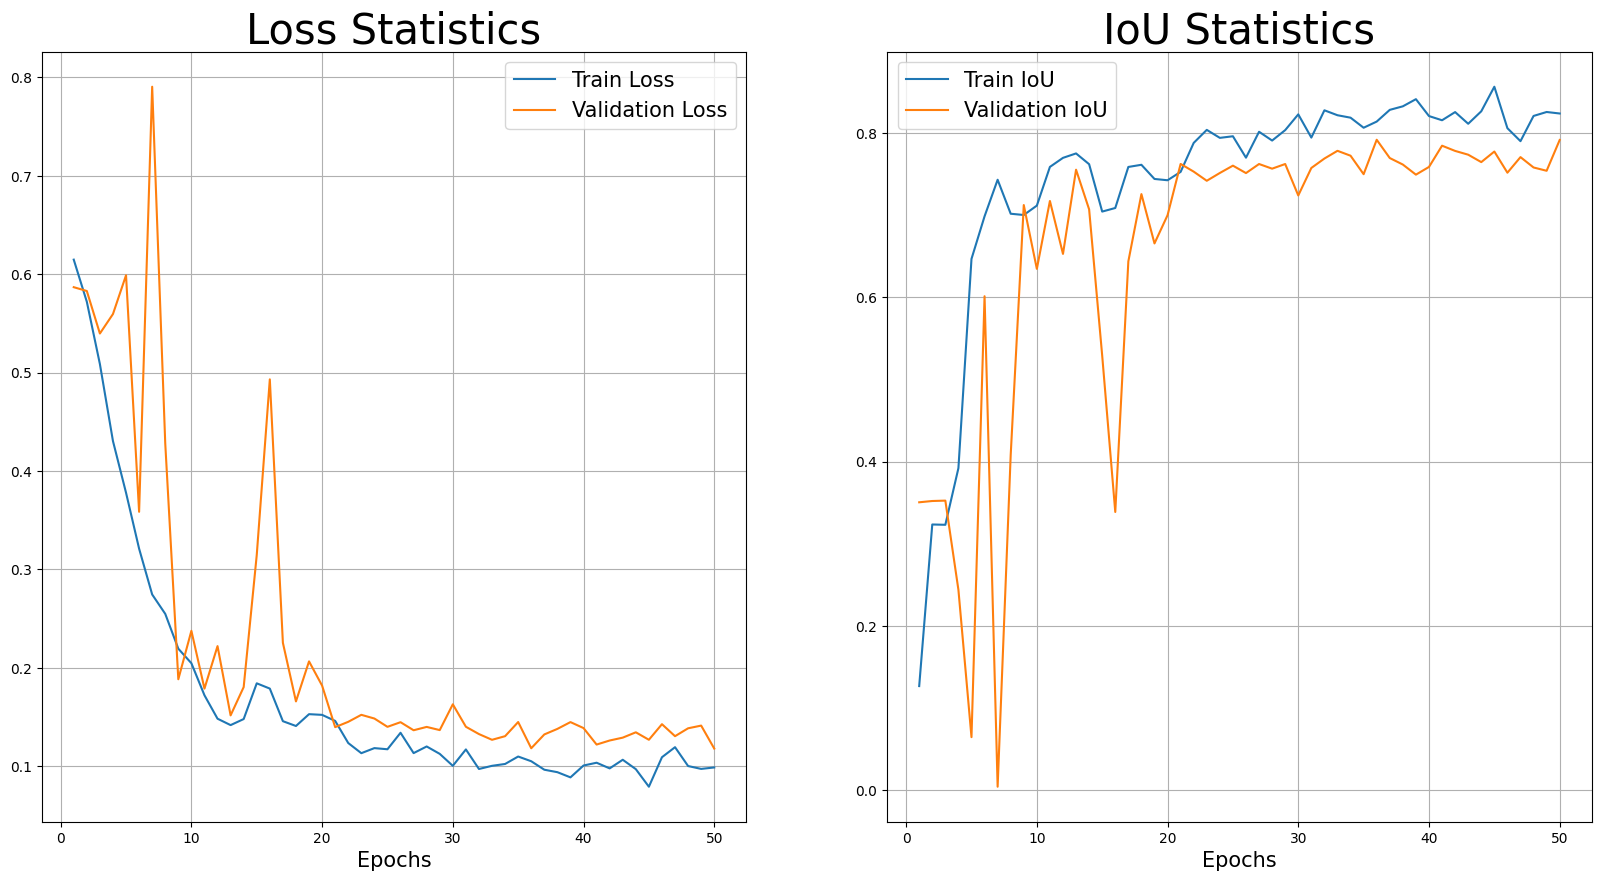

In [40]:
draw_statistics(statistics)

### SegNet + FocalLoss

In [40]:
torch.cuda.empty_cache()

In [32]:
segnet_focal = SegNet().to(device)
optimizer_focal = torch.optim.Adam(segnet_focal.parameters(), lr=1e-3)

best_focal_model, statistics = train(
        model=segnet_focal,
        data=dataloader,
        optimizer=optimizer_focal,
        criterion=focal_loss,
        metrics=metrics,
        epochs=50,
        device=device
)

Training Epoch 1/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 1/50: Loss - 296779.3438, Mean IoU - 0.0606


Validation Epoch 1/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 1/50: Loss - 278434.3906, Mean IoU - 0.0309


Training Epoch 2/50: 100%|██████████| 4/4 [00:04<00:00,  1.15s/batch]


Training Epoch 2/50: Loss - 256654.4688, Mean IoU - 0.0073


Validation Epoch 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.76batch/s]


Validation Epoch 2/50: Loss - 510071.6562, Mean IoU - 0.1719


Training Epoch 3/50: 100%|██████████| 4/4 [00:04<00:00,  1.16s/batch]


Training Epoch 3/50: Loss - 227629.0469, Mean IoU - 0.0011


Validation Epoch 3/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 3/50: Loss - 914033.3438, Mean IoU - 0.0963


Training Epoch 4/50: 100%|██████████| 4/4 [00:04<00:00,  1.16s/batch]


Training Epoch 4/50: Loss - 177802.5703, Mean IoU - 0.4298


Validation Epoch 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 4/50: Loss - 1872832.7500, Mean IoU - 0.1335


Training Epoch 5/50: 100%|██████████| 4/4 [00:04<00:00,  1.16s/batch]


Training Epoch 5/50: Loss - 146569.5605, Mean IoU - 0.6634


Validation Epoch 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 5/50: Loss - 598000.1875, Mean IoU - 0.3940


Training Epoch 6/50: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 6/50: Loss - 132962.4062, Mean IoU - 0.6963


Validation Epoch 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.59batch/s]


Validation Epoch 6/50: Loss - 414044.6406, Mean IoU - 0.5175


Training Epoch 7/50: 100%|██████████| 4/4 [00:04<00:00,  1.17s/batch]


Training Epoch 7/50: Loss - 113225.0332, Mean IoU - 0.7128


Validation Epoch 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 7/50: Loss - 502248.4375, Mean IoU - 0.4315


Training Epoch 8/50: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 8/50: Loss - 106723.8125, Mean IoU - 0.7273


Validation Epoch 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 8/50: Loss - 796643.4375, Mean IoU - 0.2814


Training Epoch 9/50: 100%|██████████| 4/4 [00:04<00:00,  1.18s/batch]


Training Epoch 9/50: Loss - 101798.8828, Mean IoU - 0.7508


Validation Epoch 9/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 9/50: Loss - 283880.4531, Mean IoU - 0.5330


Training Epoch 10/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 10/50: Loss - 100427.3047, Mean IoU - 0.7441


Validation Epoch 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 10/50: Loss - 248175.4609, Mean IoU - 0.5753


Training Epoch 11/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 11/50: Loss - 112297.1992, Mean IoU - 0.7353


Validation Epoch 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 11/50: Loss - 182055.7578, Mean IoU - 0.6522


Training Epoch 12/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 12/50: Loss - 94836.3066, Mean IoU - 0.7438


Validation Epoch 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 12/50: Loss - 215515.0703, Mean IoU - 0.6090


Training Epoch 13/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 13/50: Loss - 94392.4531, Mean IoU - 0.7536


Validation Epoch 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 13/50: Loss - 198730.5312, Mean IoU - 0.6271


Training Epoch 14/50: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 14/50: Loss - 96421.9062, Mean IoU - 0.7399


Validation Epoch 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 14/50: Loss - 142296.9219, Mean IoU - 0.7135


Training Epoch 15/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 15/50: Loss - 84592.7285, Mean IoU - 0.7715


Validation Epoch 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 15/50: Loss - 180209.8047, Mean IoU - 0.6725


Training Epoch 16/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 16/50: Loss - 78271.2500, Mean IoU - 0.7845


Validation Epoch 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 16/50: Loss - 134334.2773, Mean IoU - 0.7137


Training Epoch 17/50: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 17/50: Loss - 74772.6641, Mean IoU - 0.7999


Validation Epoch 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 17/50: Loss - 146144.6406, Mean IoU - 0.7041


Training Epoch 18/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 18/50: Loss - 73516.5488, Mean IoU - 0.7962


Validation Epoch 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 18/50: Loss - 167632.6562, Mean IoU - 0.6711


Training Epoch 19/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 19/50: Loss - 76216.6992, Mean IoU - 0.7858


Validation Epoch 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 19/50: Loss - 173864.6719, Mean IoU - 0.6934


Training Epoch 20/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 20/50: Loss - 74709.3203, Mean IoU - 0.7900


Validation Epoch 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 20/50: Loss - 177327.0312, Mean IoU - 0.6664


Training Epoch 21/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 21/50: Loss - 77579.1660, Mean IoU - 0.7781


Validation Epoch 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.62batch/s]


Validation Epoch 21/50: Loss - 179988.6250, Mean IoU - 0.6639


Training Epoch 22/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 22/50: Loss - 74377.9756, Mean IoU - 0.7945


Validation Epoch 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 22/50: Loss - 260156.8828, Mean IoU - 0.6043


Training Epoch 23/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 23/50: Loss - 84585.5967, Mean IoU - 0.7657


Validation Epoch 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 23/50: Loss - 176203.5000, Mean IoU - 0.6665


Training Epoch 24/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 24/50: Loss - 78924.6533, Mean IoU - 0.7756


Validation Epoch 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 24/50: Loss - 118881.3125, Mean IoU - 0.7328


Training Epoch 25/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 25/50: Loss - 84323.7227, Mean IoU - 0.7781


Validation Epoch 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 25/50: Loss - 126104.1172, Mean IoU - 0.7423


Training Epoch 26/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 26/50: Loss - 85588.4072, Mean IoU - 0.7765


Validation Epoch 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.58batch/s]


Validation Epoch 26/50: Loss - 131038.2461, Mean IoU - 0.7387


Training Epoch 27/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 27/50: Loss - 74977.0674, Mean IoU - 0.7914


Validation Epoch 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.74batch/s]


Validation Epoch 27/50: Loss - 133761.9258, Mean IoU - 0.6961


Training Epoch 28/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 28/50: Loss - 79725.9258, Mean IoU - 0.7853


Validation Epoch 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 28/50: Loss - 116294.7383, Mean IoU - 0.7286


Training Epoch 29/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 29/50: Loss - 73573.1055, Mean IoU - 0.7852


Validation Epoch 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 29/50: Loss - 109213.5586, Mean IoU - 0.7640


Training Epoch 30/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 30/50: Loss - 63835.9160, Mean IoU - 0.8199


Validation Epoch 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 30/50: Loss - 212542.8828, Mean IoU - 0.6445


Training Epoch 31/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 31/50: Loss - 65712.4131, Mean IoU - 0.8149


Validation Epoch 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.52batch/s]


Validation Epoch 31/50: Loss - 149615.0625, Mean IoU - 0.7011


Training Epoch 32/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 32/50: Loss - 61497.6016, Mean IoU - 0.8177


Validation Epoch 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.56batch/s]


Validation Epoch 32/50: Loss - 125827.7695, Mean IoU - 0.7110


Training Epoch 33/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 33/50: Loss - 59372.5186, Mean IoU - 0.8261


Validation Epoch 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 33/50: Loss - 118646.0898, Mean IoU - 0.7367


Training Epoch 34/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 34/50: Loss - 58946.6152, Mean IoU - 0.8301


Validation Epoch 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 34/50: Loss - 111939.0859, Mean IoU - 0.7609


Training Epoch 35/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 35/50: Loss - 70558.4375, Mean IoU - 0.8031


Validation Epoch 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 35/50: Loss - 105853.6289, Mean IoU - 0.7728


Training Epoch 36/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 36/50: Loss - 56269.2168, Mean IoU - 0.8348


Validation Epoch 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 36/50: Loss - 115000.5625, Mean IoU - 0.7534


Training Epoch 37/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 37/50: Loss - 66078.8037, Mean IoU - 0.8151


Validation Epoch 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 37/50: Loss - 143108.8906, Mean IoU - 0.7291


Training Epoch 38/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 38/50: Loss - 60544.6699, Mean IoU - 0.8349


Validation Epoch 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 38/50: Loss - 121777.8203, Mean IoU - 0.7539


Training Epoch 39/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 39/50: Loss - 62283.1572, Mean IoU - 0.8252


Validation Epoch 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 39/50: Loss - 127259.4961, Mean IoU - 0.7485


Training Epoch 40/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 40/50: Loss - 68204.3428, Mean IoU - 0.8248


Validation Epoch 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 40/50: Loss - 159898.6953, Mean IoU - 0.6903


Training Epoch 41/50: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 41/50: Loss - 61129.2969, Mean IoU - 0.8339


Validation Epoch 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.47batch/s]


Validation Epoch 41/50: Loss - 119214.0625, Mean IoU - 0.7612


Training Epoch 42/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 42/50: Loss - 58732.6533, Mean IoU - 0.8295


Validation Epoch 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 42/50: Loss - 136424.3789, Mean IoU - 0.7337


Training Epoch 43/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 43/50: Loss - 60629.6885, Mean IoU - 0.8286


Validation Epoch 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 43/50: Loss - 164644.6484, Mean IoU - 0.7018


Training Epoch 44/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 44/50: Loss - 53855.0439, Mean IoU - 0.8515


Validation Epoch 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 44/50: Loss - 129029.7773, Mean IoU - 0.7532


Training Epoch 45/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 45/50: Loss - 55973.2725, Mean IoU - 0.8375


Validation Epoch 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 45/50: Loss - 109224.6289, Mean IoU - 0.7729


Training Epoch 46/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 46/50: Loss - 60842.3535, Mean IoU - 0.8264


Validation Epoch 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 46/50: Loss - 116899.5156, Mean IoU - 0.7588


Training Epoch 47/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 47/50: Loss - 47156.8086, Mean IoU - 0.8654


Validation Epoch 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 47/50: Loss - 118489.3086, Mean IoU - 0.7545


Training Epoch 48/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 48/50: Loss - 51430.4814, Mean IoU - 0.8530


Validation Epoch 48/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 48/50: Loss - 112743.7578, Mean IoU - 0.7677


Training Epoch 49/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 49/50: Loss - 51585.4727, Mean IoU - 0.8545


Validation Epoch 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 49/50: Loss - 111936.0430, Mean IoU - 0.7650


Training Epoch 50/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 50/50: Loss - 59694.8457, Mean IoU - 0.8388


Validation Epoch 50/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 50/50: Loss - 108274.8086, Mean IoU - 0.7772


In [33]:
focal_inference = test(
    test_data=test_loader,
    device=device,
    metrics=metrics,
    best_model=best_focal_model
)

Inference: 100%|██████████| 2/2 [00:02<00:00,  1.17s/batch]

Mean IoU - 0.8020


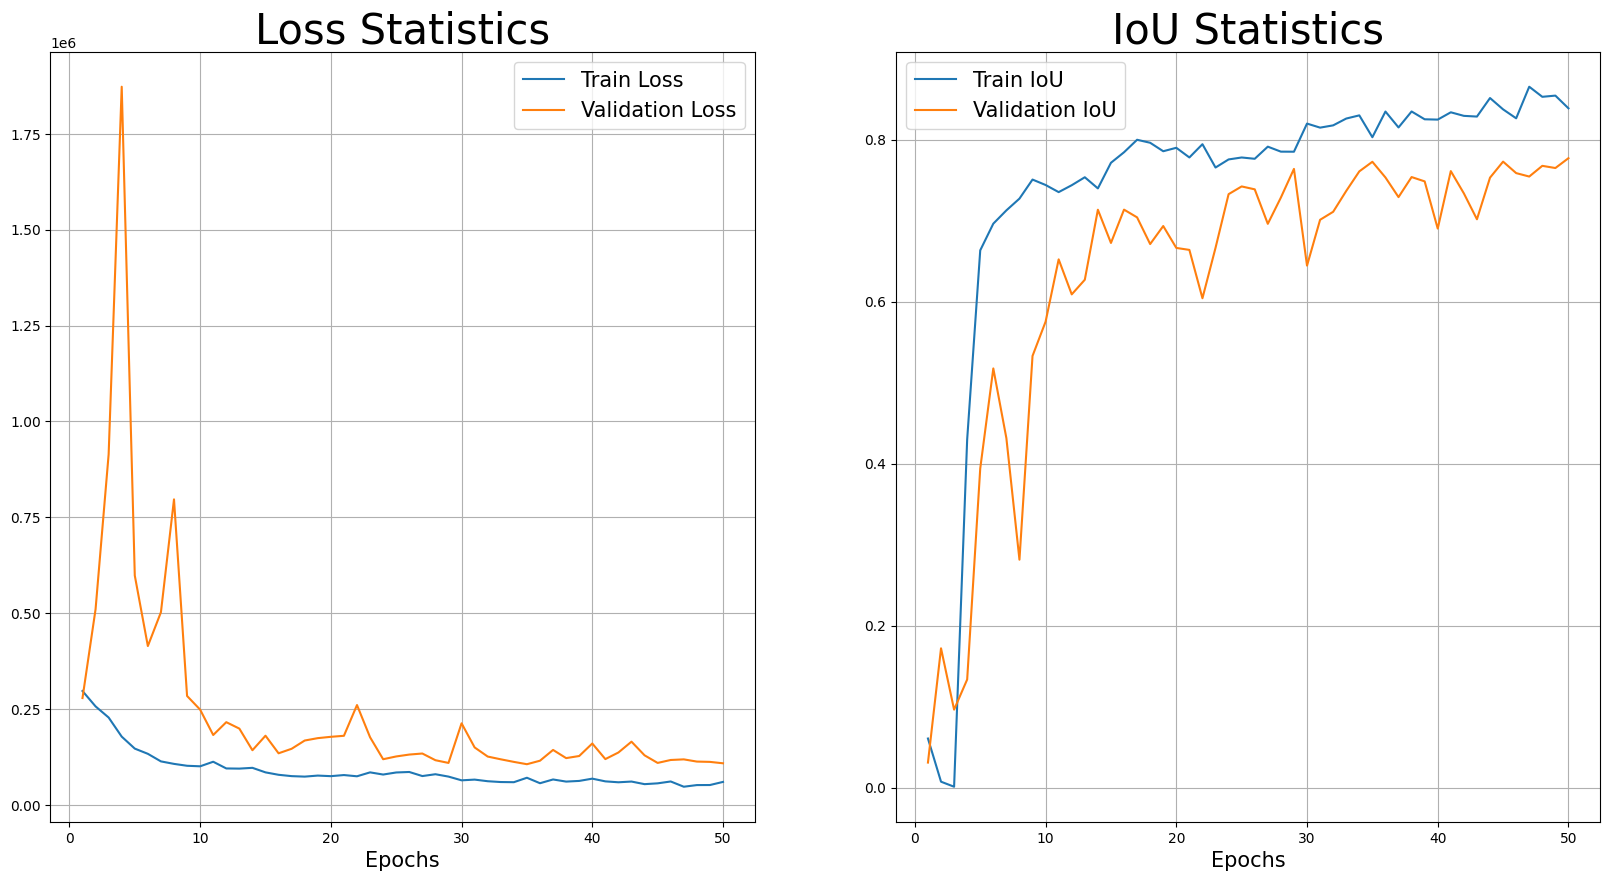

In [34]:
draw_statistics(statistics)

### SegNet + Tversky

In [40]:
torch.cuda.empty_cache()

In [41]:
segnet_tversky = SegNet().to(device)
optimizer_tversky = torch.optim.Adam(segnet_tversky.parameters(), lr=1e-3)

best_tversky_model, statistics = train(
        model=segnet_tversky,
        data=dataloader,
        optimizer=optimizer_tversky,
        criterion=tversky_loss,
        metrics=metrics,
        epochs=50,
        device=device
)

Training Epoch 1/50: 100%|██████████| 4/4 [00:04<00:00,  1.23s/batch]


Training Epoch 1/50: Loss - 0.5465, Mean IoU - 0.2292


Validation Epoch 1/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 1/50: Loss - 0.5512, Mean IoU - 0.0000


Training Epoch 2/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 2/50: Loss - 0.4234, Mean IoU - 0.3364


Validation Epoch 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.73batch/s]


Validation Epoch 2/50: Loss - 0.3365, Mean IoU - 0.3525


Training Epoch 3/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 3/50: Loss - 0.3339, Mean IoU - 0.4501


Validation Epoch 3/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 3/50: Loss - 0.3410, Mean IoU - 0.3721


Training Epoch 4/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 4/50: Loss - 0.2918, Mean IoU - 0.5870


Validation Epoch 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 4/50: Loss - 0.3489, Mean IoU - 0.3613


Training Epoch 5/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 5/50: Loss - 0.2638, Mean IoU - 0.6645


Validation Epoch 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.63batch/s]


Validation Epoch 5/50: Loss - 0.3327, Mean IoU - 0.3851


Training Epoch 6/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 6/50: Loss - 0.2237, Mean IoU - 0.6383


Validation Epoch 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.58batch/s]


Validation Epoch 6/50: Loss - 0.3101, Mean IoU - 0.4316


Training Epoch 7/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 7/50: Loss - 0.1944, Mean IoU - 0.6664


Validation Epoch 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 7/50: Loss - 0.2790, Mean IoU - 0.4582


Training Epoch 8/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 8/50: Loss - 0.1611, Mean IoU - 0.6911


Validation Epoch 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 8/50: Loss - 0.2205, Mean IoU - 0.5533


Training Epoch 9/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 9/50: Loss - 0.1578, Mean IoU - 0.6995


Validation Epoch 9/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 9/50: Loss - 0.2111, Mean IoU - 0.5663


Training Epoch 10/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 10/50: Loss - 0.1334, Mean IoU - 0.7361


Validation Epoch 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 10/50: Loss - 0.1893, Mean IoU - 0.6034


Training Epoch 11/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 11/50: Loss - 0.1368, Mean IoU - 0.7283


Validation Epoch 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.59batch/s]


Validation Epoch 11/50: Loss - 0.1963, Mean IoU - 0.6136


Training Epoch 12/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 12/50: Loss - 0.1147, Mean IoU - 0.7651


Validation Epoch 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 12/50: Loss - 0.1406, Mean IoU - 0.6954


Training Epoch 13/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 13/50: Loss - 0.1314, Mean IoU - 0.7382


Validation Epoch 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 13/50: Loss - 0.1350, Mean IoU - 0.7041


Training Epoch 14/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 14/50: Loss - 0.1258, Mean IoU - 0.7266


Validation Epoch 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 14/50: Loss - 0.1426, Mean IoU - 0.7226


Training Epoch 15/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 15/50: Loss - 0.1107, Mean IoU - 0.7637


Validation Epoch 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 15/50: Loss - 0.1489, Mean IoU - 0.7233


Training Epoch 16/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 16/50: Loss - 0.1126, Mean IoU - 0.7698


Validation Epoch 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 16/50: Loss - 0.1504, Mean IoU - 0.6647


Training Epoch 17/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 17/50: Loss - 0.1216, Mean IoU - 0.7534


Validation Epoch 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 17/50: Loss - 0.1642, Mean IoU - 0.6405


Training Epoch 18/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 18/50: Loss - 0.1085, Mean IoU - 0.7686


Validation Epoch 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 18/50: Loss - 0.1748, Mean IoU - 0.6496


Training Epoch 19/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 19/50: Loss - 0.1228, Mean IoU - 0.7552


Validation Epoch 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.61batch/s]


Validation Epoch 19/50: Loss - 0.4042, Mean IoU - 0.4418


Training Epoch 20/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 20/50: Loss - 0.1090, Mean IoU - 0.7497


Validation Epoch 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 20/50: Loss - 0.1660, Mean IoU - 0.6662


Training Epoch 21/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 21/50: Loss - 0.1076, Mean IoU - 0.7613


Validation Epoch 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 21/50: Loss - 0.1668, Mean IoU - 0.6431


Training Epoch 22/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 22/50: Loss - 0.1049, Mean IoU - 0.7721


Validation Epoch 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 22/50: Loss - 0.1373, Mean IoU - 0.6894


Training Epoch 23/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 23/50: Loss - 0.1105, Mean IoU - 0.7625


Validation Epoch 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.66batch/s]


Validation Epoch 23/50: Loss - 0.1298, Mean IoU - 0.7219


Training Epoch 24/50: 100%|██████████| 4/4 [00:04<00:00,  1.21s/batch]


Training Epoch 24/50: Loss - 0.1033, Mean IoU - 0.7962


Validation Epoch 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 24/50: Loss - 0.1465, Mean IoU - 0.7423


Training Epoch 25/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 25/50: Loss - 0.1114, Mean IoU - 0.7617


Validation Epoch 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 25/50: Loss - 0.1198, Mean IoU - 0.7702


Training Epoch 26/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 26/50: Loss - 0.1116, Mean IoU - 0.7655


Validation Epoch 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 26/50: Loss - 0.1493, Mean IoU - 0.6826


Training Epoch 27/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 27/50: Loss - 0.1109, Mean IoU - 0.7588


Validation Epoch 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 27/50: Loss - 0.1364, Mean IoU - 0.6935


Training Epoch 28/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 28/50: Loss - 0.0991, Mean IoU - 0.7989


Validation Epoch 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 28/50: Loss - 0.1430, Mean IoU - 0.6837


Training Epoch 29/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 29/50: Loss - 0.0900, Mean IoU - 0.7999


Validation Epoch 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 29/50: Loss - 0.1486, Mean IoU - 0.6752


Training Epoch 30/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 30/50: Loss - 0.0920, Mean IoU - 0.7815


Validation Epoch 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 30/50: Loss - 0.1447, Mean IoU - 0.7003


Training Epoch 31/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 31/50: Loss - 0.0996, Mean IoU - 0.7877


Validation Epoch 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.58batch/s]


Validation Epoch 31/50: Loss - 0.1226, Mean IoU - 0.7331


Training Epoch 32/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 32/50: Loss - 0.0960, Mean IoU - 0.8093


Validation Epoch 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 32/50: Loss - 0.1215, Mean IoU - 0.7446


Training Epoch 33/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 33/50: Loss - 0.1040, Mean IoU - 0.7685


Validation Epoch 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 33/50: Loss - 0.1168, Mean IoU - 0.7634


Training Epoch 34/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 34/50: Loss - 0.0849, Mean IoU - 0.8099


Validation Epoch 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 34/50: Loss - 0.1141, Mean IoU - 0.7700


Training Epoch 35/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 35/50: Loss - 0.0821, Mean IoU - 0.8278


Validation Epoch 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 35/50: Loss - 0.1215, Mean IoU - 0.7704


Training Epoch 36/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 36/50: Loss - 0.0755, Mean IoU - 0.8393


Validation Epoch 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.68batch/s]


Validation Epoch 36/50: Loss - 0.1034, Mean IoU - 0.7883


Training Epoch 37/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 37/50: Loss - 0.0768, Mean IoU - 0.8132


Validation Epoch 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.60batch/s]


Validation Epoch 37/50: Loss - 0.1042, Mean IoU - 0.7846


Training Epoch 38/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 38/50: Loss - 0.0829, Mean IoU - 0.8151


Validation Epoch 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 38/50: Loss - 0.1114, Mean IoU - 0.7630


Training Epoch 39/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 39/50: Loss - 0.0818, Mean IoU - 0.8183


Validation Epoch 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 39/50: Loss - 0.1173, Mean IoU - 0.7374


Training Epoch 40/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 40/50: Loss - 0.0809, Mean IoU - 0.8200


Validation Epoch 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.69batch/s]


Validation Epoch 40/50: Loss - 0.1185, Mean IoU - 0.7537


Training Epoch 41/50: 100%|██████████| 4/4 [00:04<00:00,  1.22s/batch]


Training Epoch 41/50: Loss - 0.0683, Mean IoU - 0.8427


Validation Epoch 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.56batch/s]


Validation Epoch 41/50: Loss - 0.1186, Mean IoU - 0.7541


Training Epoch 42/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 42/50: Loss - 0.0738, Mean IoU - 0.8378


Validation Epoch 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 42/50: Loss - 0.1103, Mean IoU - 0.7779


Training Epoch 43/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 43/50: Loss - 0.0610, Mean IoU - 0.8660


Validation Epoch 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.65batch/s]


Validation Epoch 43/50: Loss - 0.1115, Mean IoU - 0.7670


Training Epoch 44/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 44/50: Loss - 0.0675, Mean IoU - 0.8481


Validation Epoch 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 44/50: Loss - 0.1107, Mean IoU - 0.7621


Training Epoch 45/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 45/50: Loss - 0.0851, Mean IoU - 0.8015


Validation Epoch 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.57batch/s]


Validation Epoch 45/50: Loss - 0.1078, Mean IoU - 0.7725


Training Epoch 46/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 46/50: Loss - 0.0639, Mean IoU - 0.8504


Validation Epoch 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s]


Validation Epoch 46/50: Loss - 0.1161, Mean IoU - 0.7746


Training Epoch 47/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 47/50: Loss - 0.0640, Mean IoU - 0.8541


Validation Epoch 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.71batch/s]


Validation Epoch 47/50: Loss - 0.1169, Mean IoU - 0.7774


Training Epoch 48/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 48/50: Loss - 0.0561, Mean IoU - 0.8713


Validation Epoch 48/50: 100%|██████████| 2/2 [00:01<00:00,  1.67batch/s]


Validation Epoch 48/50: Loss - 0.1163, Mean IoU - 0.7671


Training Epoch 49/50: 100%|██████████| 4/4 [00:04<00:00,  1.20s/batch]


Training Epoch 49/50: Loss - 0.0557, Mean IoU - 0.8741


Validation Epoch 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.72batch/s]


Validation Epoch 49/50: Loss - 0.1205, Mean IoU - 0.7511


Training Epoch 50/50: 100%|██████████| 4/4 [00:04<00:00,  1.19s/batch]


Training Epoch 50/50: Loss - 0.0659, Mean IoU - 0.8524


Validation Epoch 50/50: 100%|██████████| 2/2 [00:01<00:00,  1.64batch/s]


Validation Epoch 50/50: Loss - 0.1070, Mean IoU - 0.7945


In [42]:
tversky_inference = test(
    test_data=test_loader,
    device=device,
    metrics=metrics,
    best_model=best_tversky_model
)

Inference: 100%|██████████| 2/2 [00:01<00:00,  1.37batch/s]

Mean IoU - 0.8561


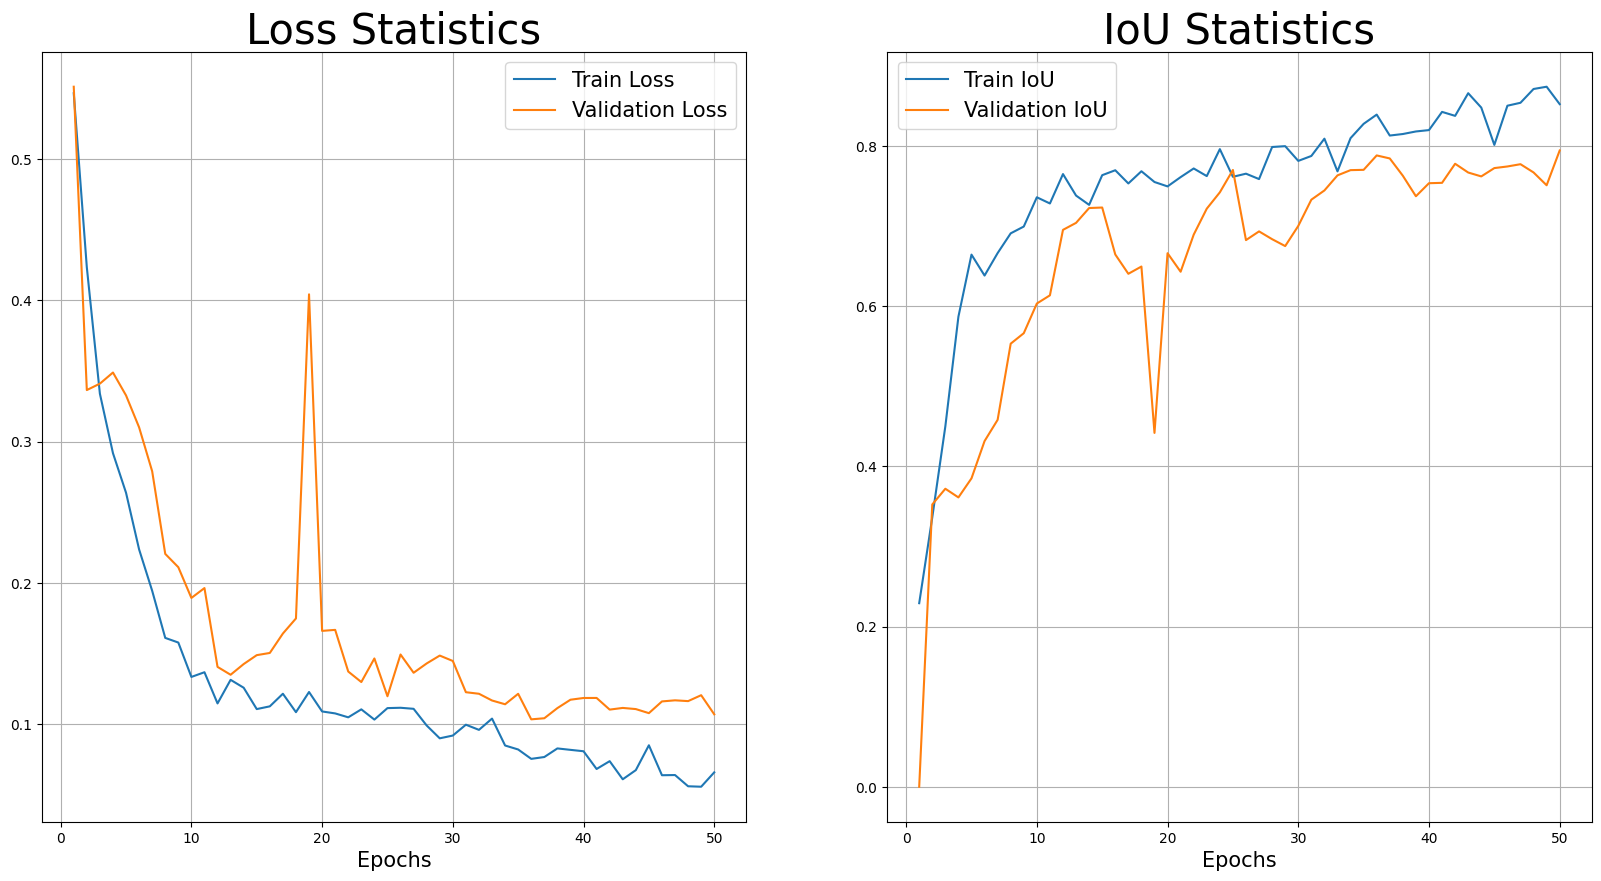

In [43]:
draw_statistics(statistics)

## U-Net 
[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

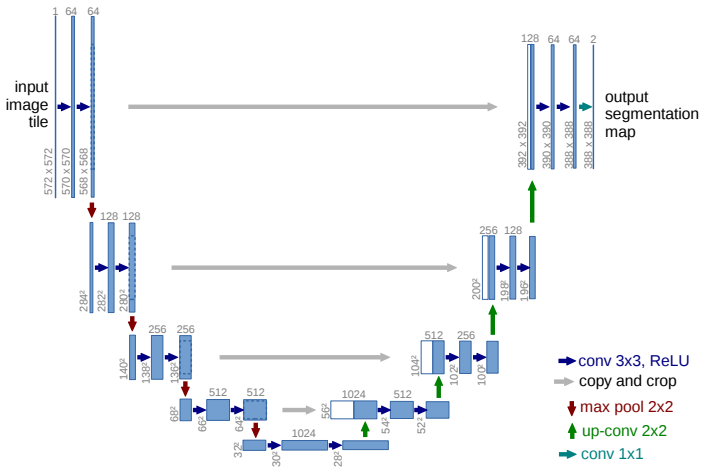

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # TODO

    def forward(self, x):
        #  TODO

        return output

In [ ]:
unet_model = UNet().to(device)